# GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Jan 26 03:29:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CFG

In [2]:
CONFIG_NAME = 'config24.yml'

from requests import get
filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
TITLE = filename.split('.')[0]

In [3]:
! rm -r cassava

rm: cannot remove 'cassava': No such file or directory


In [4]:
! git clone https://github.com/raijin0704/cassava.git
# ====================================================
# CFG
# ====================================================
import yaml

CONFIG_PATH = f'./cassava/config/{CONFIG_NAME}'
with open(CONFIG_PATH) as f:
    config = yaml.load(f)

INFO = config['info']
TAG = config['tag']
CFG = config['cfg']

CFG['train'] = True
CFG['inference'] = False

# CFG['debug'] = True

if CFG['debug']:
    CFG['epochs'] = 1


assert INFO['TITLE'] == TITLE, f'{TITLE}, {INFO["TITLE"]}'

Cloning into 'cassava'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 176 (delta 123), reused 10 (delta 5), pack-reused 0
Receiving objects: 100% (176/176), 30.67 KiB | 10.22 MiB/s, done.
Resolving deltas: 100% (123/123), done.


# colab & kaggle notebookでの環境面の処理

## colab

In [5]:
def _colab_kaggle_authority():
    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)


def _install_apex():
    import os
    import subprocess
    import sys
    # import time
    subprocess.run('git clone https://github.com/NVIDIA/apex'.split(' '))
    # time.sleep(10)
    os.chdir('apex')
    subprocess.run('pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .'.split(' '))
    os.chdir('..')


def process_colab():
    import subprocess
    
    # ドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Cloudの権限設定
    from google.colab import auth
    auth.authenticate_user()

    # kaggle設定
    # _colab_kaggle_authority()
    # subprocess.run('pip install --upgrade --force-reinstall --no-deps kaggle'.split(' '))

    # ライブラリ関係
    subprocess.run('pip install --upgrade opencv-python'.split(' '))
    subprocess.run('pip install --upgrade albumentations'.split(' '))
    subprocess.run('pip install timm'.split(' '))
    # if CFG['apex']:
    #     print('installing apex')
    #     _install_apex()
    #     print('done')

    # 各種pathの設定
    # DATA_PATH = '/content/drive/Shareddrives/便利用/kaggle/cassava/input/'
    DATA_PATH = '/content/input'
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = f'/content/drive/Shareddrives/便利用/kaggle/cassava/notebook/{TITLE}.ipynb'

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## kaggle notebook

In [6]:
def _kaggle_gcp_authority():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

def process_kaggle():
    # GCP設定
    _kaggle_gcp_authority()

    # 各種pathの設定
    DATA_PATH = '../input/cassava-leaf-disease-classification/'
    ! mkdir output
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = './__notebook__.ipynb'
    # system path
    import sys
    sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## 共通

In [7]:
def process_common():
    # ライブラリ関係
    import subprocess
    subprocess.run('pip install mlflow'.split(' '))

    # 環境変数
    import os
    os.environ["GCLOUD_PROJECT"] = INFO['PROJECT_ID']

In [8]:
try:
    from google.colab import auth
except ImportError:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_kaggle()
    env = 'kaggle'
else:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_colab()
    env = 'colab'
finally:
    process_common()

Mounted at /content/drive


In [9]:
!rm -r /content/input

rm: cannot remove '/content/input': No such file or directory


In [10]:
import os

if env=='colab':
    ! cp /content/drive/Shareddrives/便利用/kaggle/cassava/input.zip /content/input.zip
    ! unzip input.zip
    ! rm input.zip
train_num = len(os.listdir(DATA_PATH+"/train_images"))
assert train_num == 21397

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: input/train_images/1137739472.jpg  
  inflating: input/train_images/441313044.jpg  
  inflating: input/train_images/982733151.jpg  
  inflating: input/train_images/3643480526.jpg  
  inflating: input/train_images/2440664696.jpg  
  inflating: input/train_images/370523815.jpg  
  inflating: input/train_images/1125560878.jpg  
  inflating: input/train_images/3303165486.jpg  
  inflating: input/train_images/510873412.jpg  
  inflating: input/train_images/550429661.jpg  
  inflating: input/train_images/1127352598.jpg  
  inflating: input/train_images/3767196717.jpg  
  inflating: input/train_images/25671501.jpg  
  inflating: input/train_images/2296550892.jpg  
  inflating: input/train_images/754482252.jpg  
  inflating: input/train_images/3714169299.jpg  
  inflating: input/train_images/127776052.jpg  
  inflating: input/train_images/3761357668.jpg  
  inflating: input/train_images/996534381.jpg  
  inflating: input/train_images/255701322.jpg  

# install apex

In [11]:
if CFG['apex']:
    try:
        import apex
    except Exception:
        ! git clone https://github.com/NVIDIA/apex.git
        % cd apex
        !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
        %cd ..

# Library

In [12]:
# ====================================================
# Library
# ====================================================
import os
import datetime
import math
import time
import random
import glob
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, CenterCrop
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import mlflow

import warnings 
warnings.filterwarnings('ignore')

if CFG['apex']:
    from apex import amp

if CFG['debug']:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda')
start_time = datetime.datetime.now()
start_time_str = start_time.strftime('%m%d%H%M')

# Directory settings

In [13]:
# ====================================================
# Directory settings
# ====================================================
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# save basic files

In [14]:
# with open(f'{OUTPUT_DIR}/{start_time_str}_TAG.json', 'w') as f:
#     json.dump(TAG, f, indent=4)
    
# with open(f'{OUTPUT_DIR}/{start_time_str}_CFG.json', 'w') as f:
#     json.dump(CFG, f, indent=4)

import shutil
notebook_path = f'{OUTPUT_DIR}/{start_time_str}_{TITLE}.ipynb'
shutil.copy2(NOTEBOOK_PATH, notebook_path)

'./output//01260333_24t-efficientnet_b3-cutmix-tta-RandomBrightness.ipynb'

# Data Loading

In [15]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
label_map = pd.read_json(f'{DATA_PATH}/label_num_to_disease_map.json', 
                         orient='index')

if CFG['debug']:
    train = train.sample(n=1000, random_state=CFG['seed']).reset_index(drop=True)

# Utils

In [16]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, FileHandler,  Formatter,  StreamHandler
    from logging import INFO as INFO_
    logger = getLogger(__name__)
    logger.setLevel(INFO_)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger_path = OUTPUT_DIR+f'{start_time_str}_train.log'
LOGGER = init_logger(logger_path)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG['seed'])


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, save_path='checkpoint.pt',
                 counter=0, best_score=None, save_latest_path=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            save_path (str): Directory for saving a model.
                             Default: "'checkpoint.pt'"
        """
        self.patience = patience
        self.verbose = verbose
        self.save_path = save_path
        self.counter = counter
        self.best_score = best_score
        self.save_latest_path = save_latest_path
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, preds, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.save_latest(val_loss, model, preds, epoch, score)
        elif score >= self.best_score:
            self.counter = 0
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.save_latest(val_loss, model, preds, epoch, score)
        # nanになったら学習ストップ
        elif math.isnan(score):
            self.early_stop = True
        else:
            self.counter += 1
            if self.save_latest_path is not None:
                self.save_latest(val_loss, model, preds, epoch, score)
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, preds, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.10f} --> {val_loss:.10f}).  Saving model ...')
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'best_score' : self.best_score, 'counter' : self.counter},
                   self.save_path)
        self.val_loss_min = val_loss

    def save_latest(self, val_loss, model, preds, epoch, score):
        '''Saves latest model.'''
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'score' : score, 'counter' : self.counter},
                   self.save_latest_path)
        self.val_loss_min = val_loss

In [17]:
def remove_glob(pathname, recursive=True):
    for p in glob.glob(pathname, recursive=recursive):
        if os.path.isfile(p):
            os.remove(p)


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# CV split

In [18]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG['n_fold'], shuffle=True, random_state=CFG['seed'])
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG['target_col']])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG['target_col']]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [19]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/test_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [20]:
# train_dataset = TrainDataset(train, transform=None)

# for i in range(1):
#     image, label = train_dataset[i]
#     plt.imshow(image)
#     plt.title(f'label: {label}')
#     plt.show() 

# Transforms

In [21]:
def _get_train_augmentations(aug_list):
    process = []
    for aug in aug_list:
        if aug ==  'Resize':
            process.append(Resize(CFG['size'], CFG['size']))
        elif aug == 'RandomResizedCrop':
            process.append(RandomResizedCrop(CFG['size'], CFG['size']))
        elif aug =='CenterCrop':
            process.append(CenterCrop(CFG['size'], CFG['size']))
        elif aug == 'Transpose':
            process.append(Transpose(p=0.5))
        elif aug == 'HorizontalFlip':
            process.append(HorizontalFlip(p=0.5))
        elif aug == 'VerticalFlip':
            process.append(VerticalFlip(p=0.5))
        elif aug == 'ShiftScaleRotate':
            process.append(ShiftScaleRotate(p=0.5))
        elif aug == 'RandomBrightness':
            process.append(RandomBrightness(limit=(-0.2,0.2), p=1))
        elif aug == 'Cutout':
            process.append(Cutout(max_h_size=CFG['CutoutSize'], max_w_size=CFG['CutoutSize'], p=0.5))
        elif aug == 'Normalize':
            process.append(Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ))
        elif aug in ['mixup', 'cutmix', 'fmix']:
            pass
        else:
            raise ValueError(f'{aug} is not suitable')

    process.append(ToTensorV2())

    return process



def _get_valid_augmentations(aug_list):
    process = []
    for aug in aug_list:
        if aug ==  'Resize':
            process.append(Resize(CFG['size'], CFG['size']))
        elif aug == 'RandomResizedCrop':
            process.append(OneOf(
                [RandomResizedCrop(CFG['size'], CFG['size'], p=0.5), 
                 Resize(CFG['size'], CFG['size'], p=0.5)], p=1))
        elif aug =='CenterCrop':
            process.append(OneOf(
                [CenterCrop(CFG['size'], CFG['size'], p=0.5), 
                 Resize(CFG['size'], CFG['size'], p=0.5)], p=1))
        elif aug == 'Transpose':
            process.append(Transpose(p=0.5))
        elif aug == 'HorizontalFlip':
            process.append(HorizontalFlip(p=0.5))
        elif aug == 'VerticalFlip':
            process.append(VerticalFlip(p=0.5))
        elif aug == 'ShiftScaleRotate':
            process.append(ShiftScaleRotate(p=0.5))
        elif aug == 'RandomBrightness':
            process.append(RandomBrightness(limit=(-0.2,0.2), p=1))
        elif aug == 'Normalize':
            process.append(Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ))
        elif aug in ['mixup', 'cutmix', 'fmix']:
            pass
        else:
            raise ValueError(f'{aug} is not suitable')

    process.append(ToTensorV2())

    return process

In [22]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose(
            _get_train_augmentations(TAG['augmentation'])
        )

    elif data == 'valid':
        try:
            augmentations = TAG['valid_augmentation']
        except KeyError:
             augmentations = ['Resize', 'Normalize']
        return Compose(
            _get_valid_augmentations(augmentations)
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

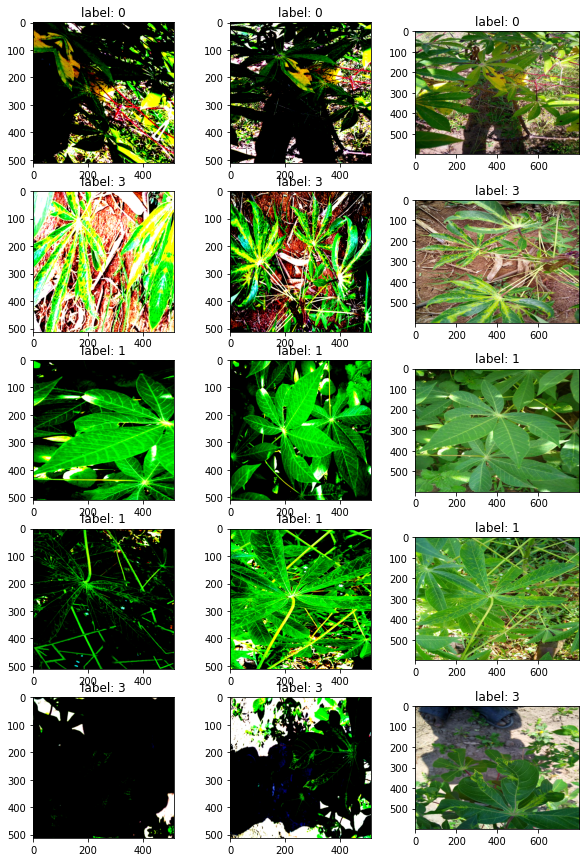

In [23]:
num_fig = 5

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
valid_dataset = TrainDataset(train, transform=get_transforms(data='valid'))
origin_dataset = TrainDataset(train, transform=None)

fig, ax = plt.subplots(num_fig, 3, figsize=(10, num_fig*3))

for j, dataset in enumerate([train_dataset, valid_dataset, origin_dataset]):
    for i in range(num_fig):
        image, label = dataset[i]
        if j < 2:
            ax[i,j].imshow(image.transpose(0,2).transpose(0,1))
        else:
            ax[i,j].imshow(image)
        ax[i,j].set_title(f'label: {label}') 

# Bi-tempered logistic loss

In [24]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

# MODEL

In [25]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.model, 'classifier'):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG['target_size'])
        elif hasattr(self.model, 'fc'):
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG['target_size'])

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
model = CustomModel(model_name=TAG['model_name'], pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0012,  0.0478, -0.1190, -0.0258,  0.0694],
        [ 0.3390, -0.0559,  0.0824, -0.2227,  0.6753],
        [-0.0713,  0.0454, -0.0540, -0.0214,  0.0076],
        [-0.1406,  0.0663, -0.0423,  0.0017, -0.0475]],
       grad_fn=<AddmmBackward>)


# Helper functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))




In [28]:
# ====================================================
# loss
# ====================================================
def get_loss(criterion, y_preds, labels):
    if TAG['criterion']=='CrossEntropyLoss':
        loss = criterion(y_preds, labels)
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        loss = criterion(y_preds, labels, t1=CFG['bi_tempered_loss_t1'], t2=CFG['bi_tempered_loss_t2'])
    return loss

In [29]:
# ====================================================
# Helper functions
# ====================================================
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        r = np.random.rand(1)
        is_aug = r < 0.5    # probability of augmentation
        if is_aug & ('cutmix' in TAG['augmentation']) & (epoch+1>=CFG['heavy_aug_start_epoch']):
            # generate mixed sample
            # inference from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
            lam = np.random.beta(CFG['CutmixAlpha'], CFG['CutmixAlpha'])
            rand_index = torch.randperm(images.size()[0]).to(device)
            labels_a = labels
            labels_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
            # compute output
            y_preds = model(images)
            loss = get_loss(criterion, y_preds, labels_a) * lam + \
                    get_loss(criterion, y_preds, labels_b) * (1. - lam)
        else:
            y_preds = model(images)
            loss = get_loss(criterion, y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        if CFG['apex']:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        # clear memory
        del loss, y_preds
        torch.cuda.empty_cache()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG['max_grad_norm'])
        if (step + 1) % CFG['gradient_accumulation_steps'] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            # model.load_state_dict(state['model'])
            model.load_state_dict(state)
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [30]:
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if TAG['scheduler']=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG['factor'], patience=CFG['patience'], verbose=True, eps=CFG['eps'])
    elif TAG['scheduler']=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG['T_max'], eta_min=CFG['min_lr'], last_epoch=-1)
    elif TAG['scheduler']=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    return scheduler

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if TAG['criterion']=='CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        criterion = bi_tempered_logistic_loss
    return criterion

In [31]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    if not CFG['debug']:
        mlflow.set_tag('running.fold', str(fold))
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=True, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=False, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & criterion
    # ====================================================
    best_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'
    latest_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_latest.pth'

    model = CustomModel(TAG['model_name'], pretrained=True)
    model.to(device)
    # 学習途中の重みがあれば読み込み
    if os.path.isfile(latest_model_path):
        state_latest = torch.load(latest_model_path)
        state_best = torch.load(best_model_path)
        model.load_state_dict(state_latest['model'])
        epoch_start = state_latest['epoch']+1
        # er_best_score = state_latest['score']
        er_counter = state_latest['counter']
        er_best_score = state_best['best_score']

        LOGGER.info(f'Load training model in epoch:{epoch_start}, best_score:{er_best_score:.3f}, counter:{er_counter}')

    # 学習済みモデルを再学習する場合
    elif os.path.isfile(best_model_path):
        state_best = torch.load(best_model_path)
        model.load_state_dict(state_best['model'])
        epoch_start = 0 # epochは0からカウントしなおす
        er_counter = 0
        er_best_score = state_best['best_score']

        LOGGER.info(f'Retrain model, best_score:{er_best_score:.3f}')
    else:
        epoch_start = 0
        er_best_score = None
        er_counter = 0

    optimizer = Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    # 再開時のepochまでschedulerを進める
    for _ in range(epoch_start):
        if isinstance(scheduler, ReduceLROnPlateau):
            # TODO avg_val_lossを履歴から取得する
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

    # ====================================================
    # apex
    # ====================================================
    if CFG['apex']:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    # best_score = 0.
    # best_loss = np.inf
    early_stopping = EarlyStopping(
                            patience=CFG['early_stopping_round'], 
                            verbose=True,
                            save_path=best_model_path,
                            counter=er_counter, best_score=er_best_score, 
                            save_latest_path=latest_model_path)
    
    for epoch in range(epoch_start, CFG['epochs']):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG['target_col']].values
        
        # early stopping
        early_stopping(avg_val_loss, model, preds, epoch)
        if early_stopping.early_stop:
            print(f'Epoch {epoch+1} - early stopping')
            break
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric(f"fold{fold} avg_train_loss", avg_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} avg_valid_loss", avg_val_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} score", score, step=epoch)
            mlflow.log_metric(f"fold{fold} lr", scheduler.get_last_lr()[0], step=epoch)
            mlflow.log_artifact(best_model_path)
            if os.path.isfile(latest_model_path):
                mlflow.log_artifact(latest_model_path)
    
    check_point = torch.load(best_model_path)
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [32]:
def get_trained_fold_preds(folds, fold, best_model_path):
    val_idx = folds[folds['fold'] == fold].index
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    check_point = torch.load(best_model_path)
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds


def save_confusion_matrix(oof):
    from sklearn.metrics import confusion_matrix
    cm_ = confusion_matrix(oof['label'], oof['preds'], labels=[0,1,2,3,4])
    label_name = ['0 (CBB)', '1 (CBSD)', '2 (CGM)', '3 (CMD)', '4 (Healthy)']
    cm = pd.DataFrame(cm_, index=label_name, columns=label_name)
    cm.to_csv(OUTPUT_DIR+'oof_confusion_matrix.csv', index=True)

In [33]:
# ====================================================
# main
# ====================================================
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG['target_col']].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.5f}')
    
    return score

    

def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """
    
    if CFG['train']:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG['n_fold']):
            best_model_path = OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'
            if fold in CFG['trn_fold']:
                _oof_df = train_loop(folds, fold)
            elif os.path.exists(best_model_path):
                _oof_df = get_trained_fold_preds(folds, fold, best_model_path)
            else:
                _oof_df = None
            if _oof_df is not None:
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                _ = get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        score = get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        save_confusion_matrix(oof_df)
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric('oof score', score)
            mlflow.delete_tag('running.fold')
            mlflow.log_artifact(OUTPUT_DIR+'oof_df.csv')
    
    if CFG['inference']:
        # inference
        model = CustomModel(TAG['model_name'], pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth') for fold in CFG['trn_fold']]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'], shuffle=False, 
                                 num_workers=CFG['num_workers'], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

# rerun

In [34]:
def _load_save_point(run_id):
    # どこで中断したか取得
    stop_fold = int(mlflow.get_run(run_id=run_id).to_dictionary()['data']['tags']['running.fold'])
    # 学習対象のfoldを変更
    CFG['trn_fold'] = [fold for fold in CFG['trn_fold'] if fold>=stop_fold]
    # 学習済みモデルがあれば.pthファイルを取得(学習中も含む)
    client = mlflow.tracking.MlflowClient()
    artifacts = [artifact for artifact in client.list_artifacts(run_id) if ".pth" in artifact.path]
    for artifact in artifacts:
        client.download_artifacts(run_id, artifact.path, OUTPUT_DIR)


def check_have_run():
    results = mlflow.search_runs(INFO['EXPERIMENT_ID'])
    run_id_list = results[results['tags.mlflow.runName']==TITLE]['run_id'].tolist()
    # 初めて実行する場合
    if len(run_id_list) == 0:
        run_id = None
    # 既に実行されている場合
    else:
        assert len(run_id_list)==1
        run_id = run_id_list[0]
        _load_save_point(run_id)

    return run_id

In [35]:
if __name__ == '__main__':
    if CFG['debug']:
        main()
    else:
        mlflow.set_tracking_uri(INFO['TRACKING_URI'])
        mlflow.set_experiment('single model')
        # 既に実行済みの場合は続きから実行する
        run_id = check_have_run()
        with mlflow.start_run(run_id=run_id, run_name=TITLE):
            if run_id is None:
                mlflow.log_artifact(CONFIG_PATH)
                mlflow.log_param('device', device)
                mlflow.set_tag('env', env)
                mlflow.set_tags(TAG)
                mlflow.log_params(CFG)
            mlflow.log_artifact(notebook_path)
            main()
            mlflow.log_artifacts(OUTPUT_DIR)
            remove_glob(f'{OUTPUT_DIR}/*latest.pth')
            if env=="kaggle":
                shutil.copy2(CONFIG_PATH, f'{OUTPUT_DIR}/{CONFIG_NAME}')
                ! rm -r cassava
            elif env=="colab":
                shutil.copytree(OUTPUT_DIR, f'{INFO["SHARE_DRIVE_PATH"]}/{TITLE}')
                shutil.copy2(CONFIG_PATH, f'{INFO["SHARE_DRIVE_PATH"]}/{TITLE}/{CONFIG_NAME}')

========== fold: 0 result ==========
Score: 0.89650
========== fold: 1 result ==========
Score: 0.89626
========== fold: 2 result ==========
Score: 0.89811
========== fold: 3 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
Load training model in epoch:20, best_score:-0.103, counter:1


Epoch: [21][0/1069] Data 1.339 (1.339) Elapsed 0m 2s (remain 53m 13s) Loss: 0.1416(0.1416) Grad: 0.0325  
Epoch: [21][100/1069] Data 0.000 (0.013) Elapsed 1m 53s (remain 18m 3s) Loss: 0.0862(0.1274) Grad: 0.3256  
Epoch: [21][200/1069] Data 0.000 (0.007) Elapsed 3m 46s (remain 16m 19s) Loss: 0.1529(0.1238) Grad: 0.0471  
Epoch: [21][300/1069] Data 0.000 (0.005) Elapsed 5m 40s (remain 14m 29s) Loss: 0.1198(0.1252) Grad: 0.2634  
Epoch: [21][400/1069] Data 0.000 (0.003) Elapsed 7m 34s (remain 12m 37s) Loss: 0.1427(0.1260) Grad: 0.1632  
Epoch: [21][500/1069] Data 0.000 (0.003) Elapsed 9m 28s (remain 10m 44s) Loss: 0.2363(0.1260) Grad: 0.2740  
Epoch: [21][600/1069] Data 0.000 (0.002) Elapsed 11m 23s (remain 8m 51s) Loss: 0.2573(0.1246) Grad: 0.0948  
Epoch: [21][700/1069] Data 0.000 (0.002) Elapsed 13m 17s (remain 6m 58s) Loss: 0.0806(0.1248) Grad: 0.2704  
Epoch: [21][800/1069] Data 0.000 (0.002) Elapsed 15m 10s (remain 5m 4s) Loss: 0.0524(0.1247) Grad: 0.0545  
Epoch: [21][900/1069] Da

Epoch 21 - avg_train_loss: 0.1240  avg_val_loss: 0.1095  time: 1283s
Epoch 21 - Accuracy: 0.8794110773545221


EarlyStopping counter: 2 out of 5
Epoch: [22][0/1069] Data 1.480 (1.480) Elapsed 0m 2s (remain 46m 52s) Loss: 0.2407(0.2407) Grad: 0.2650  
Epoch: [22][100/1069] Data 0.000 (0.015) Elapsed 1m 56s (remain 18m 36s) Loss: 0.1361(0.1236) Grad: 0.3407  
Epoch: [22][200/1069] Data 0.000 (0.008) Elapsed 3m 50s (remain 16m 34s) Loss: 0.0686(0.1237) Grad: 0.0378  
Epoch: [22][300/1069] Data 0.000 (0.005) Elapsed 5m 44s (remain 14m 37s) Loss: 0.0252(0.1217) Grad: 0.2092  
Epoch: [22][400/1069] Data 0.000 (0.004) Elapsed 7m 37s (remain 12m 42s) Loss: 0.0061(0.1231) Grad: 0.0277  
Epoch: [22][500/1069] Data 0.000 (0.003) Elapsed 9m 32s (remain 10m 48s) Loss: 0.0076(0.1218) Grad: 0.2079  
Epoch: [22][600/1069] Data 0.000 (0.003) Elapsed 11m 26s (remain 8m 54s) Loss: 0.2401(0.1224) Grad: 0.0728  
Epoch: [22][700/1069] Data 0.000 (0.002) Elapsed 13m 19s (remain 6m 59s) Loss: 0.0422(0.1218) Grad: 0.3316  
Epoch: [22][800/1069] Data 0.000 (0.002) Elapsed 15m 13s (remain 5m 5s) Loss: 0.0501(0.1232) Grad

Epoch 22 - avg_train_loss: 0.1256  avg_val_loss: 0.1111  time: 1285s
Epoch 22 - Accuracy: 0.8794110773545221


EarlyStopping counter: 3 out of 5
Epoch: [23][0/1069] Data 1.231 (1.231) Elapsed 0m 2s (remain 45m 3s) Loss: 0.1123(0.1123) Grad: 0.2900  
Epoch: [23][100/1069] Data 0.000 (0.012) Elapsed 1m 56s (remain 18m 39s) Loss: 0.2518(0.1319) Grad: 0.3301  
Epoch: [23][200/1069] Data 0.000 (0.006) Elapsed 3m 50s (remain 16m 35s) Loss: 0.0806(0.1354) Grad: 0.2255  
Epoch: [23][300/1069] Data 0.000 (0.004) Elapsed 5m 44s (remain 14m 38s) Loss: 0.2538(0.1365) Grad: 0.3030  
Epoch: [23][400/1069] Data 0.000 (0.003) Elapsed 7m 38s (remain 12m 43s) Loss: 0.2206(0.1385) Grad: 0.0611  
Epoch: [23][500/1069] Data 0.000 (0.003) Elapsed 9m 32s (remain 10m 48s) Loss: 0.0258(0.1371) Grad: 0.2282  
Epoch: [23][600/1069] Data 0.000 (0.002) Elapsed 11m 26s (remain 8m 54s) Loss: 0.1343(0.1366) Grad: 0.2824  
Epoch: [23][700/1069] Data 0.000 (0.002) Elapsed 13m 20s (remain 7m 0s) Loss: 0.3520(0.1358) Grad: 0.3399  
Epoch: [23][800/1069] Data 0.000 (0.002) Elapsed 15m 14s (remain 5m 5s) Loss: 0.3182(0.1346) Grad: 

Epoch 23 - avg_train_loss: 0.1339  avg_val_loss: 0.1176  time: 1286s
Epoch 23 - Accuracy: 0.8719326945548025


EarlyStopping counter: 4 out of 5
Epoch: [24][0/1069] Data 1.356 (1.356) Elapsed 0m 2s (remain 46m 1s) Loss: 0.0451(0.0451) Grad: 0.3688  
Epoch: [24][100/1069] Data 0.000 (0.014) Elapsed 1m 56s (remain 18m 34s) Loss: 0.0846(0.1277) Grad: 0.2397  
Epoch: [24][200/1069] Data 0.000 (0.007) Elapsed 3m 50s (remain 16m 34s) Loss: 0.0227(0.1311) Grad: 0.0876  
Epoch: [24][300/1069] Data 0.000 (0.005) Elapsed 5m 44s (remain 14m 38s) Loss: 0.0532(0.1273) Grad: 0.3370  
Epoch: [24][400/1069] Data 0.000 (0.004) Elapsed 7m 38s (remain 12m 43s) Loss: 0.2762(0.1307) Grad: 0.0872  
Epoch: [24][500/1069] Data 0.000 (0.003) Elapsed 9m 32s (remain 10m 49s) Loss: 0.0264(0.1279) Grad: 0.2505  
Epoch: [24][600/1069] Data 0.000 (0.002) Elapsed 11m 26s (remain 8m 54s) Loss: 0.1470(0.1295) Grad: 0.2275  
Epoch: [24][700/1069] Data 0.000 (0.002) Elapsed 13m 20s (remain 7m 0s) Loss: 0.2425(0.1301) Grad: 0.4239  
Epoch: [24][800/1069] Data 0.000 (0.002) Elapsed 15m 14s (remain 5m 6s) Loss: 0.0238(0.1307) Grad: 

========== fold: 3 result ==========
Score: 0.88595
========== fold: 4 training ==========


EarlyStopping counter: 5 out of 5
Epoch 24 - early stopping
Epoch: [1][0/1069] Data 1.522 (1.522) Elapsed 0m 2s (remain 49m 2s) Loss: 0.5013(0.5013) Grad: 0.0834  
Epoch: [1][100/1069] Data 0.000 (0.015) Elapsed 1m 55s (remain 18m 22s) Loss: 0.3845(0.4467) Grad: 0.1761  
Epoch: [1][200/1069] Data 0.000 (0.008) Elapsed 3m 47s (remain 16m 21s) Loss: 0.2181(0.3898) Grad: 0.0712  
Epoch: [1][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 26s) Loss: 0.2186(0.3567) Grad: 0.1382  
Epoch: [1][400/1069] Data 0.000 (0.004) Elapsed 7m 31s (remain 12m 32s) Loss: 0.2439(0.3362) Grad: 0.0520  
Epoch: [1][500/1069] Data 0.000 (0.003) Elapsed 9m 24s (remain 10m 39s) Loss: 0.2849(0.3211) Grad: 0.1624  
Epoch: [1][600/1069] Data 0.000 (0.003) Elapsed 11m 16s (remain 8m 46s) Loss: 0.1836(0.3109) Grad: 0.0359  
Epoch: [1][700/1069] Data 0.000 (0.002) Elapsed 13m 8s (remain 6m 53s) Loss: 0.1823(0.3009) Grad: 0.1953  
Epoch: [1][800/1069] Data 0.000 (0.002) Elapsed 15m 0s (remain 5m 1s) Loss: 0.301

Epoch 1 - avg_train_loss: 0.2732  avg_val_loss: 0.1407  time: 1268s
Epoch 1 - Accuracy: 0.8415517644309418


Epoch: [2][0/1069] Data 1.448 (1.448) Elapsed 0m 2s (remain 48m 43s) Loss: 0.1533(0.1533) Grad: 0.2534  
Epoch: [2][100/1069] Data 0.000 (0.015) Elapsed 1m 54s (remain 18m 20s) Loss: 0.1625(0.2150) Grad: 0.1806  
Epoch: [2][200/1069] Data 0.000 (0.007) Elapsed 3m 46s (remain 16m 19s) Loss: 0.2679(0.2170) Grad: 0.0808  
Epoch: [2][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 25s) Loss: 0.0652(0.2149) Grad: 0.2011  
Epoch: [2][400/1069] Data 0.000 (0.004) Elapsed 7m 31s (remain 12m 32s) Loss: 0.2000(0.2141) Grad: 0.0510  
Epoch: [2][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 38s) Loss: 0.2290(0.2124) Grad: 0.1917  
Epoch: [2][600/1069] Data 0.000 (0.003) Elapsed 11m 15s (remain 8m 46s) Loss: 0.5310(0.2099) Grad: 0.1457  
Epoch: [2][700/1069] Data 0.000 (0.002) Elapsed 13m 7s (remain 6m 53s) Loss: 0.1217(0.2072) Grad: 0.2179  
Epoch: [2][800/1069] Data 0.000 (0.002) Elapsed 14m 59s (remain 5m 0s) Loss: 0.1585(0.2055) Grad: 0.0641  
Epoch: [2][900/1069] Data 0.000 (

Epoch 2 - avg_train_loss: 0.2005  avg_val_loss: 0.1224  time: 1266s
Epoch 2 - Accuracy: 0.866557606917504


Epoch: [3][0/1069] Data 1.494 (1.494) Elapsed 0m 2s (remain 49m 10s) Loss: 0.1348(0.1348) Grad: 0.2216  
Epoch: [3][100/1069] Data 0.000 (0.015) Elapsed 1m 54s (remain 18m 19s) Loss: 0.3329(0.2010) Grad: 0.1925  
Epoch: [3][200/1069] Data 0.000 (0.008) Elapsed 3m 47s (remain 16m 20s) Loss: 0.1795(0.1933) Grad: 0.1012  
Epoch: [3][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 26s) Loss: 0.2735(0.1911) Grad: 0.2753  
Epoch: [3][400/1069] Data 0.000 (0.004) Elapsed 7m 31s (remain 12m 31s) Loss: 0.1325(0.1890) Grad: 0.1085  
Epoch: [3][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 39s) Loss: 0.2261(0.1917) Grad: 0.2060  
Epoch: [3][600/1069] Data 0.000 (0.003) Elapsed 11m 16s (remain 8m 46s) Loss: 0.0406(0.1912) Grad: 0.0737  
Epoch: [3][700/1069] Data 0.000 (0.002) Elapsed 13m 8s (remain 6m 54s) Loss: 0.1681(0.1899) Grad: 0.2628  
Epoch: [3][800/1069] Data 0.000 (0.002) Elapsed 15m 1s (remain 5m 1s) Loss: 0.2622(0.1878) Grad: 0.0882  
Epoch: [3][900/1069] Data 0.000 (0

Epoch 3 - avg_train_loss: 0.1883  avg_val_loss: 0.1155  time: 1267s
Epoch 3 - Accuracy: 0.87146529562982


Epoch: [4][0/1069] Data 1.287 (1.287) Elapsed 0m 2s (remain 46m 22s) Loss: 0.2241(0.2241) Grad: 0.3015  
Epoch: [4][100/1069] Data 0.000 (0.013) Elapsed 1m 54s (remain 18m 21s) Loss: 0.1611(0.1734) Grad: 0.2487  
Epoch: [4][200/1069] Data 0.000 (0.007) Elapsed 3m 47s (remain 16m 20s) Loss: 0.1080(0.1714) Grad: 0.0878  
Epoch: [4][300/1069] Data 0.000 (0.004) Elapsed 5m 39s (remain 14m 26s) Loss: 0.0834(0.1729) Grad: 0.1938  
Epoch: [4][400/1069] Data 0.000 (0.003) Elapsed 7m 31s (remain 12m 32s) Loss: 0.4032(0.1729) Grad: 0.1213  
Epoch: [4][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 39s) Loss: 0.2594(0.1741) Grad: 0.2124  
Epoch: [4][600/1069] Data 0.000 (0.002) Elapsed 11m 16s (remain 8m 46s) Loss: 0.1223(0.1758) Grad: 0.0989  
Epoch: [4][700/1069] Data 0.000 (0.002) Elapsed 13m 8s (remain 6m 53s) Loss: 0.0815(0.1791) Grad: 0.1747  
Epoch: [4][800/1069] Data 0.000 (0.002) Elapsed 15m 0s (remain 5m 1s) Loss: 0.2186(0.1785) Grad: 0.1052  
Epoch: [4][900/1069] Data 0.000 (0

Epoch 4 - avg_train_loss: 0.1775  avg_val_loss: 0.1103  time: 1267s
Epoch 4 - Accuracy: 0.8773077821921009


Epoch: [5][0/1069] Data 1.559 (1.559) Elapsed 0m 2s (remain 50m 5s) Loss: 0.0676(0.0676) Grad: 0.2748  
Epoch: [5][100/1069] Data 0.000 (0.016) Elapsed 1m 54s (remain 18m 21s) Loss: 0.1362(0.1926) Grad: 0.2147  
Epoch: [5][200/1069] Data 0.000 (0.008) Elapsed 3m 47s (remain 16m 20s) Loss: 0.1452(0.1873) Grad: 0.0959  
Epoch: [5][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 25s) Loss: 0.3619(0.1895) Grad: 0.2268  
Epoch: [5][400/1069] Data 0.000 (0.004) Elapsed 7m 31s (remain 12m 31s) Loss: 0.1967(0.1833) Grad: 0.0878  
Epoch: [5][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 39s) Loss: 0.2357(0.1834) Grad: 0.2086  
Epoch: [5][600/1069] Data 0.000 (0.003) Elapsed 11m 16s (remain 8m 46s) Loss: 0.1843(0.1809) Grad: 0.0933  
Epoch: [5][700/1069] Data 0.000 (0.002) Elapsed 13m 8s (remain 6m 53s) Loss: 0.3002(0.1819) Grad: 0.2601  
Epoch: [5][800/1069] Data 0.000 (0.002) Elapsed 15m 1s (remain 5m 1s) Loss: 0.0950(0.1797) Grad: 0.1095  
Epoch: [5][900/1069] Data 0.000 (0.

Epoch 5 - avg_train_loss: 0.1774  avg_val_loss: 0.1070  time: 1267s
Epoch 5 - Accuracy: 0.8817480719794345


Epoch: [6][0/1069] Data 1.301 (1.301) Elapsed 0m 2s (remain 46m 59s) Loss: 0.2756(0.2756) Grad: 0.2232  
Epoch: [6][100/1069] Data 0.000 (0.013) Elapsed 1m 54s (remain 18m 20s) Loss: 0.0710(0.1744) Grad: 0.2221  
Epoch: [6][200/1069] Data 0.000 (0.007) Elapsed 3m 46s (remain 16m 19s) Loss: 0.1387(0.1767) Grad: 0.1038  
Epoch: [6][300/1069] Data 0.000 (0.005) Elapsed 5m 38s (remain 14m 24s) Loss: 0.2054(0.1723) Grad: 0.1967  
Epoch: [6][400/1069] Data 0.000 (0.003) Elapsed 7m 31s (remain 12m 31s) Loss: 0.2090(0.1672) Grad: 0.0457  
Epoch: [6][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 38s) Loss: 0.1954(0.1678) Grad: 0.2676  
Epoch: [6][600/1069] Data 0.000 (0.002) Elapsed 11m 15s (remain 8m 45s) Loss: 0.1954(0.1674) Grad: 0.0917  
Epoch: [6][700/1069] Data 0.000 (0.002) Elapsed 13m 7s (remain 6m 53s) Loss: 0.1448(0.1687) Grad: 0.1996  
Epoch: [6][800/1069] Data 0.000 (0.002) Elapsed 14m 59s (remain 5m 1s) Loss: 0.1763(0.1664) Grad: 0.1382  
Epoch: [6][900/1069] Data 0.000 (

Epoch 6 - avg_train_loss: 0.1680  avg_val_loss: 0.1072  time: 1266s
Epoch 6 - Accuracy: 0.8796447768170134


EarlyStopping counter: 1 out of 5
Epoch: [7][0/1069] Data 1.293 (1.293) Elapsed 0m 2s (remain 45m 32s) Loss: 0.3265(0.3265) Grad: 0.2529  
Epoch: [7][100/1069] Data 0.000 (0.013) Elapsed 1m 54s (remain 18m 19s) Loss: 0.0612(0.1796) Grad: 0.2609  
Epoch: [7][200/1069] Data 0.000 (0.007) Elapsed 3m 47s (remain 16m 21s) Loss: 0.1813(0.1690) Grad: 0.1361  
Epoch: [7][300/1069] Data 0.000 (0.004) Elapsed 5m 39s (remain 14m 25s) Loss: 0.2035(0.1725) Grad: 0.1948  
Epoch: [7][400/1069] Data 0.000 (0.003) Elapsed 7m 31s (remain 12m 31s) Loss: 0.0843(0.1697) Grad: 0.1167  
Epoch: [7][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 38s) Loss: 0.1808(0.1712) Grad: 0.2044  
Epoch: [7][600/1069] Data 0.000 (0.002) Elapsed 11m 15s (remain 8m 46s) Loss: 0.1994(0.1725) Grad: 0.0549  
Epoch: [7][700/1069] Data 0.000 (0.002) Elapsed 13m 7s (remain 6m 53s) Loss: 0.0870(0.1703) Grad: 0.2016  
Epoch: [7][800/1069] Data 0.000 (0.002) Elapsed 14m 59s (remain 5m 1s) Loss: 0.1480(0.1716) Grad: 0.0906  

Epoch 7 - avg_train_loss: 0.1709  avg_val_loss: 0.1043  time: 1266s
Epoch 7 - Accuracy: 0.8864220612292592


Epoch: [8][0/1069] Data 0.952 (0.952) Elapsed 0m 2s (remain 40m 37s) Loss: 0.2480(0.2480) Grad: 0.2251  
Epoch: [8][100/1069] Data 0.000 (0.010) Elapsed 1m 54s (remain 18m 17s) Loss: 0.2364(0.1875) Grad: 0.2273  
Epoch: [8][200/1069] Data 0.000 (0.005) Elapsed 3m 46s (remain 16m 17s) Loss: 0.2579(0.1714) Grad: 0.0560  
Epoch: [8][300/1069] Data 0.000 (0.003) Elapsed 5m 38s (remain 14m 24s) Loss: 0.1222(0.1741) Grad: 0.2494  
Epoch: [8][400/1069] Data 0.000 (0.003) Elapsed 7m 31s (remain 12m 31s) Loss: 0.2686(0.1718) Grad: 0.0971  
Epoch: [8][500/1069] Data 0.000 (0.002) Elapsed 9m 23s (remain 10m 38s) Loss: 0.2633(0.1710) Grad: 0.2085  
Epoch: [8][600/1069] Data 0.000 (0.002) Elapsed 11m 15s (remain 8m 45s) Loss: 0.3617(0.1703) Grad: 0.0936  
Epoch: [8][700/1069] Data 0.000 (0.002) Elapsed 13m 7s (remain 6m 53s) Loss: 0.0962(0.1703) Grad: 0.2734  
Epoch: [8][800/1069] Data 0.000 (0.001) Elapsed 14m 59s (remain 5m 1s) Loss: 0.2683(0.1707) Grad: 0.0602  
Epoch: [8][900/1069] Data 0.000 (

Epoch 8 - avg_train_loss: 0.1700  avg_val_loss: 0.1063  time: 1266s
Epoch 8 - Accuracy: 0.8854872633792942


EarlyStopping counter: 1 out of 5
Epoch: [9][0/1069] Data 1.480 (1.480) Elapsed 0m 2s (remain 48m 46s) Loss: 0.0779(0.0779) Grad: 0.2356  
Epoch: [9][100/1069] Data 0.000 (0.015) Elapsed 1m 54s (remain 18m 19s) Loss: 0.1814(0.1519) Grad: 0.1693  
Epoch: [9][200/1069] Data 0.000 (0.008) Elapsed 3m 46s (remain 16m 18s) Loss: 0.1099(0.1552) Grad: 0.1785  
Epoch: [9][300/1069] Data 0.000 (0.005) Elapsed 5m 38s (remain 14m 24s) Loss: 0.2933(0.1575) Grad: 0.1978  
Epoch: [9][400/1069] Data 0.000 (0.004) Elapsed 7m 30s (remain 12m 31s) Loss: 0.3524(0.1563) Grad: 0.0851  
Epoch: [9][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 38s) Loss: 0.1329(0.1615) Grad: 0.2308  
Epoch: [9][600/1069] Data 0.000 (0.003) Elapsed 11m 15s (remain 8m 45s) Loss: 0.0665(0.1603) Grad: 0.0882  
Epoch: [9][700/1069] Data 0.000 (0.002) Elapsed 13m 7s (remain 6m 53s) Loss: 0.1800(0.1624) Grad: 0.2184  
Epoch: [9][800/1069] Data 0.000 (0.002) Elapsed 14m 59s (remain 5m 1s) Loss: 0.0591(0.1612) Grad: 0.0971  

Epoch 9 - avg_train_loss: 0.1643  avg_val_loss: 0.1035  time: 1267s
Epoch 9 - Accuracy: 0.8854872633792942


Epoch: [10][0/1069] Data 1.391 (1.391) Elapsed 0m 2s (remain 46m 54s) Loss: 0.3133(0.3133) Grad: 0.2363  
Epoch: [10][100/1069] Data 0.000 (0.014) Elapsed 1m 54s (remain 18m 21s) Loss: 0.1612(0.1783) Grad: 0.2101  
Epoch: [10][200/1069] Data 0.000 (0.007) Elapsed 3m 47s (remain 16m 21s) Loss: 0.1787(0.1736) Grad: 0.1181  
Epoch: [10][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 26s) Loss: 0.0861(0.1724) Grad: 0.2567  
Epoch: [10][400/1069] Data 0.000 (0.004) Elapsed 7m 31s (remain 12m 32s) Loss: 0.0875(0.1709) Grad: 0.0856  
Epoch: [10][500/1069] Data 0.000 (0.003) Elapsed 9m 24s (remain 10m 39s) Loss: 0.1003(0.1694) Grad: 0.2288  
Epoch: [10][600/1069] Data 0.000 (0.002) Elapsed 11m 16s (remain 8m 46s) Loss: 0.1450(0.1689) Grad: 0.0961  
Epoch: [10][700/1069] Data 0.000 (0.002) Elapsed 13m 8s (remain 6m 53s) Loss: 0.1919(0.1677) Grad: 0.2401  
Epoch: [10][800/1069] Data 0.000 (0.002) Elapsed 15m 0s (remain 5m 1s) Loss: 0.1710(0.1672) Grad: 0.0600  
Epoch: [10][900/1069] Dat

Epoch 10 - avg_train_loss: 0.1656  avg_val_loss: 0.1041  time: 1266s
Epoch 10 - Accuracy: 0.8819817714419257


EarlyStopping counter: 1 out of 5
Epoch: [11][0/1069] Data 1.459 (1.459) Elapsed 0m 2s (remain 48m 23s) Loss: 0.1340(0.1340) Grad: 0.2593  
Epoch: [11][100/1069] Data 0.000 (0.015) Elapsed 1m 55s (remain 18m 22s) Loss: 0.1601(0.1675) Grad: 0.1782  
Epoch: [11][200/1069] Data 0.000 (0.007) Elapsed 3m 47s (remain 16m 22s) Loss: 0.0769(0.1568) Grad: 0.0594  
Epoch: [11][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 26s) Loss: 0.1984(0.1595) Grad: 0.2168  
Epoch: [11][400/1069] Data 0.000 (0.004) Elapsed 7m 32s (remain 12m 33s) Loss: 0.1236(0.1621) Grad: 0.0659  
Epoch: [11][500/1069] Data 0.000 (0.003) Elapsed 9m 24s (remain 10m 40s) Loss: 0.0575(0.1638) Grad: 0.2205  
Epoch: [11][600/1069] Data 0.000 (0.003) Elapsed 11m 17s (remain 8m 47s) Loss: 0.2551(0.1634) Grad: 0.0582  
Epoch: [11][700/1069] Data 0.000 (0.002) Elapsed 13m 9s (remain 6m 54s) Loss: 0.2585(0.1614) Grad: 0.1793  
Epoch: [11][800/1069] Data 0.000 (0.002) Elapsed 15m 1s (remain 5m 1s) Loss: 0.0724(0.1616) Grad: 

Epoch 11 - avg_train_loss: 0.1621  avg_val_loss: 0.1046  time: 1268s
Epoch 11 - Accuracy: 0.8819817714419257


EarlyStopping counter: 2 out of 5
Epoch: [12][0/1069] Data 1.273 (1.273) Elapsed 0m 2s (remain 45m 38s) Loss: 0.1842(0.1842) Grad: 0.2307  
Epoch: [12][100/1069] Data 0.000 (0.013) Elapsed 1m 54s (remain 18m 21s) Loss: 0.0719(0.1513) Grad: 0.2387  
Epoch: [12][200/1069] Data 0.000 (0.006) Elapsed 3m 46s (remain 16m 19s) Loss: 0.0132(0.1601) Grad: 0.0388  
Epoch: [12][300/1069] Data 0.000 (0.004) Elapsed 5m 39s (remain 14m 25s) Loss: 0.1645(0.1606) Grad: 0.2863  
Epoch: [12][400/1069] Data 0.000 (0.003) Elapsed 7m 31s (remain 12m 32s) Loss: 0.2821(0.1588) Grad: 0.0867  
Epoch: [12][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 39s) Loss: 0.1294(0.1614) Grad: 0.2767  
Epoch: [12][600/1069] Data 0.000 (0.002) Elapsed 11m 16s (remain 8m 46s) Loss: 0.2807(0.1614) Grad: 0.1272  
Epoch: [12][700/1069] Data 0.000 (0.002) Elapsed 13m 9s (remain 6m 54s) Loss: 0.1025(0.1621) Grad: 0.2281  
Epoch: [12][800/1069] Data 0.000 (0.002) Elapsed 15m 1s (remain 5m 1s) Loss: 0.1937(0.1623) Grad: 

Epoch 12 - avg_train_loss: 0.1643  avg_val_loss: 0.1037  time: 1268s
Epoch 12 - Accuracy: 0.8840850666043468


EarlyStopping counter: 3 out of 5
Epoch: [13][0/1069] Data 1.396 (1.396) Elapsed 0m 2s (remain 47m 48s) Loss: 0.0807(0.0807) Grad: 0.2760  
Epoch: [13][100/1069] Data 0.000 (0.014) Elapsed 1m 54s (remain 18m 20s) Loss: 0.1129(0.1705) Grad: 0.2035  
Epoch: [13][200/1069] Data 0.000 (0.007) Elapsed 3m 46s (remain 16m 19s) Loss: 0.0201(0.1623) Grad: 0.0642  
Epoch: [13][300/1069] Data 0.000 (0.005) Elapsed 5m 39s (remain 14m 25s) Loss: 0.1011(0.1638) Grad: 0.1864  
Epoch: [13][400/1069] Data 0.000 (0.004) Elapsed 7m 31s (remain 12m 32s) Loss: 0.3293(0.1633) Grad: 0.1106  
Epoch: [13][500/1069] Data 0.000 (0.003) Elapsed 9m 23s (remain 10m 38s) Loss: 0.2138(0.1651) Grad: 0.2895  
Epoch: [13][600/1069] Data 0.000 (0.002) Elapsed 11m 15s (remain 8m 46s) Loss: 0.2622(0.1654) Grad: 0.1233  
Epoch: [13][700/1069] Data 0.000 (0.002) Elapsed 13m 8s (remain 6m 53s) Loss: 0.1430(0.1636) Grad: 0.2139  
Epoch: [13][800/1069] Data 0.000 (0.002) Elapsed 14m 59s (remain 5m 1s) Loss: 0.2405(0.1647) Grad:

Epoch 13 - avg_train_loss: 0.1637  avg_val_loss: 0.1078  time: 1267s
Epoch 13 - Accuracy: 0.8787099789670484


EarlyStopping counter: 4 out of 5
Epoch: [14][0/1069] Data 1.425 (1.425) Elapsed 0m 2s (remain 48m 29s) Loss: 0.2955(0.2955) Grad: 0.2401  
Epoch: [14][100/1069] Data 0.000 (0.014) Elapsed 1m 54s (remain 18m 21s) Loss: 0.1696(0.1545) Grad: 0.2872  
Epoch: [14][200/1069] Data 0.000 (0.007) Elapsed 3m 46s (remain 16m 19s) Loss: 0.1229(0.1544) Grad: 0.1600  
Epoch: [14][300/1069] Data 0.000 (0.005) Elapsed 5m 38s (remain 14m 24s) Loss: 0.1844(0.1579) Grad: 0.1842  
Epoch: [14][400/1069] Data 0.000 (0.004) Elapsed 7m 30s (remain 12m 31s) Loss: 0.0426(0.1575) Grad: 0.0926  
Epoch: [14][500/1069] Data 0.000 (0.003) Elapsed 9m 22s (remain 10m 38s) Loss: 0.2670(0.1564) Grad: 0.2760  
Epoch: [14][600/1069] Data 0.000 (0.003) Elapsed 11m 14s (remain 8m 45s) Loss: 0.2132(0.1594) Grad: 0.0781  
Epoch: [14][700/1069] Data 0.000 (0.002) Elapsed 13m 6s (remain 6m 52s) Loss: 0.3889(0.1586) Grad: 0.2523  
Epoch: [14][800/1069] Data 0.000 (0.002) Elapsed 14m 59s (remain 5m 0s) Loss: 0.5130(0.1590) Grad:

========== fold: 4 result ==========
Score: 0.88549
========== CV ==========
Score: 0.89246


EarlyStopping counter: 5 out of 5
Epoch 14 - early stopping
